In [698]:
# !pip install torch torchvision torchaudio --index-url https://download.pytorch.org/whl/cpu
#!pip install lightning==2.2.5 opencv-python numpy pandas matplotlib

# Imports y configuración

In [699]:
from pathlib import Path
import re, math, json, random
import numpy as np
import pandas as pd
import cv2
import matplotlib.pyplot as plt

import torch
import torch.nn as nn
import torch.nn.functional as F
from torch.utils.data import Dataset, DataLoader

import lightning as L
from lightning.pytorch.loggers import CSVLogger
from lightning.pytorch.callbacks import EarlyStopping, ModelCheckpoint, LearningRateMonitor, RichProgressBar, Callback
from lightning import seed_everything  

seed_everything(42, workers=True)

DATA_DIR = "data"          
T_IN     = 5               
T_OUT    = 4               
BATCH    = 32
LR       = 1e-3
EPOCHS   = 80
HIDDEN   = 64              
NUM_LAY  = 1               
LAMBDA_V = 0.1 
NUM_WORKERS = 0 

Seed set to 42


# Utilidades: centroides, carga por lanzamiento, normalización

Este código constituye la base de un sistema para analizar trayectorias de una pelota en secuencias de imágenes. 

Primero, implementa una función que detecta el centro y el área del objeto blanco (la pelota) en una imagen binarizada, utilizando momentos de imagen para obtener sus coordenadas con precisión. Luego, organiza los fotogramas de cada lanzamiento de manera ordenada y carga todas las secuencias desde directorios, descartando aquellas vacías o demasiado cortas. Con esto, se obtiene un conjunto estructurado de datos numéricos (x, y, área) para cada secuencia, que puede ser usado posteriormente en tareas de análisis, modelado o predicción de trayectorias.

En resumen, este código automatiza la transición de imágenes crudas a datos listos para ser procesados en experimentos de visión por computadora o aprendizaje automático.

In [700]:
def get_ball_center(gray_img: np.ndarray):
    """Retorna (cx, cy, area) del blob blanco; None si no hay blob."""
    _, binim = cv2.threshold(gray_img, 127, 255, cv2.THRESH_BINARY)
    M = cv2.moments(binim)
    if M["m00"] == 0:
        return None
    cx = M["m10"] / M["m00"]
    cy = M["m01"] / M["m00"]
    area = M["m00"] / 255.0
    return float(cx), float(cy), float(area)

def sorted_frames_old(folder: Path):
    """Lista de paths ordenados alfabéticamente (asume nombres con orden temporal)."""
    imgs = sorted([p for p in folder.glob("*.jpg")])
    return imgs

import re

def _extract_num(s: str) -> int:
    """
    Extrae el primer número del nombre (p.ej. 'img_12.jpg' -> 12).
    Si no hay número, devuelve -1 para que queden primero (ajústalo si prefieres al final).
    """
    m = re.search(r'(\d+)', s)
    return int(m.group(1)) if m else -1

def sorted_frames(folder: Path):
    """
    Lista de paths ordenados por índice numérico en el nombre del archivo.
    Ej.: 1.jpg, 2.jpg, 10.jpg -> 1, 2, 10
    """
    imgs = [p for p in folder.iterdir()
            if p.is_file() and p.suffix.lower() in {".jpg", ".jpeg", ".png"}]
    return sorted(imgs, key=lambda p: _extract_num(p.stem))

def load_launch_sequences(base_dir: str, min_len: int = 1):
    base = Path(base_dir)
    launch_dirs = [d for d in base.iterdir() if d.is_dir()]
    sequences = {}
    width = height = None

    empty_ids = []   
    short_ids = [] 

    for d in sorted(launch_dirs):
        frames = sorted_frames(d)
        seq = []
        for fp in frames:
            img = cv2.imread(str(fp), cv2.IMREAD_GRAYSCALE)
            if img is None:
                continue
            h, w = img.shape
            if height is None: height, width = h, w
            c = get_ball_center(img)
            if c is not None:
                seq.append(c)  

        arr = np.array(seq, dtype=np.float32).reshape(-1, 3) 
        if arr.shape[0] == 0:
            empty_ids.append(d.name)
            continue  

        if arr.shape[0] < min_len:
            short_ids.append((d.name, arr.shape[0]))

        sequences[d.name] = arr

    print(f"Secuencias cargadas: {len(sequences)}  | Vacías: {len(empty_ids)}  | <{min_len}: {len(short_ids)}")
    if empty_ids:
        print("IDs vacíos (sin detecciones):", empty_ids[:10], "..." if len(empty_ids) > 10 else "")
    if short_ids:
        print("IDs cortos:", short_ids[:10], "..." if len(short_ids) > 10 else "")
    return sequences, width, height

DATA_DIR = "fotos_binarizadas_limpias"

sequences_raw, W, H = load_launch_sequences(DATA_DIR)
print(f"Lanzamientos válidos: {len(sequences_raw)}  | Tamaño imagen: {W}x{H}")

Secuencias cargadas: 1199  | Vacías: 0  | <1: 0
Lanzamientos válidos: 1199  | Tamaño imagen: 640x480


# Dibujando una Muestra de las Trayectorias :

Aqui podemos ver que trayectorias estamos cargando y mostrando 25 muestras aleatorias, para tener un idea de 
las trayectorias que estamos usando.

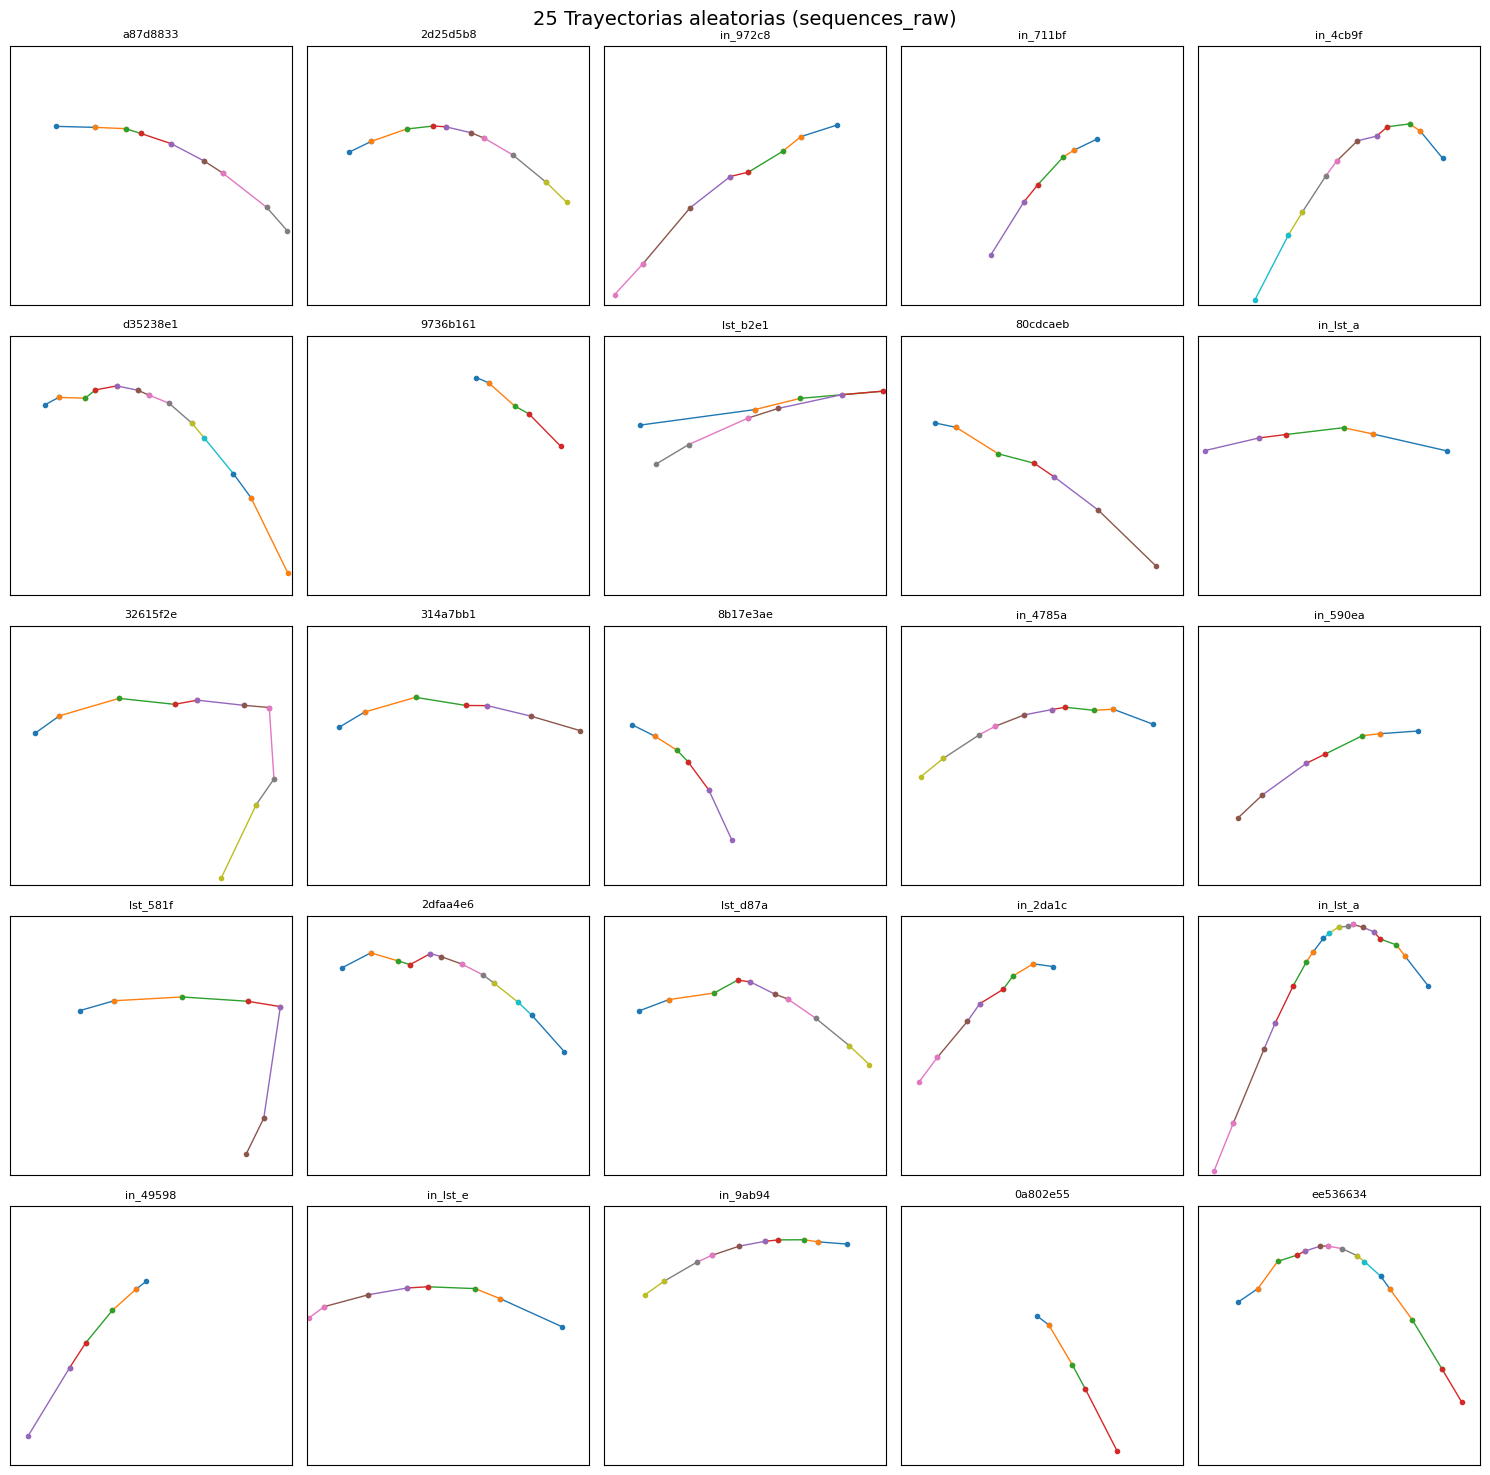

In [701]:
import matplotlib.pyplot as plt
import random

def plot_random_trajectories(sequences_raw, n_samples=25, W=640, H=480):
    ids = random.sample(list(sequences_raw.keys()), min(n_samples, len(sequences_raw)))

    fig, axes = plt.subplots(5, 5, figsize=(15, 15))
    axes = axes.flatten()

    for i, (ax, sid) in enumerate(zip(axes, ids)):
        seq = sequences_raw[sid]  
        x, y = seq[:, 0], seq[:, 1]

        for j in range(len(x) - 1):
            ax.plot([x[j], x[j+1]], [y[j], y[j+1]], "o-", markersize=3, linewidth=1)

        ax.set_title(sid[:8], fontsize=8)  
        ax.invert_yaxis()   
        ax.set_xlim(0, W)
        ax.set_ylim(H, 0)
        ax.set_xticks([])
        ax.set_yticks([])
        ax.grid(True, linestyle="--", alpha=0.3)

    for j in range(i+1, len(axes)):
        axes[j].axis("off")

    plt.suptitle("25 Trayectorias aleatorias (sequences_raw)", fontsize=14)
    plt.tight_layout()
    plt.show()


plot_random_trajectories(sequences_raw, n_samples=25, W=W, H=H)

# Creacion de lanzamientos hiperbolicos y Parabolicos Con Ruido



In [702]:
import numpy as np
import math

def sample_hyperbola_seq_safe(
    T=20, W=640, H=480,
    x_margin=0.10, y_margin=0.10,
    xc_range=(0.35, 0.65), yc_range=(0.35, 0.65),
    min_dx=0.12, max_dx=0.30,           
    k_abs_max=0.25,
    noise_xy=0.0025,
    drift=0.0,
    max_retries=500
):
    """
    Genera una secuencia hiperbólica y=yc + k/(x-xc) en normalizado, la valida y la
    devuelve en PIXELES como [T,3] (x_px, y_px, area_px). Retorna None si no pudo.
    """
    for _ in range(max_retries):
        xc = np.random.uniform(*xc_range)
        yc = np.random.uniform(*yc_range)

        dx = np.random.uniform(min_dx, max_dx)
        side_right = np.random.rand() < 0.5
        if side_right:
            x_lo = max(xc + dx, x_margin)
            x_hi = 1.0 - x_margin
        else:
            x_lo = x_margin
            x_hi = min(xc - dx, 1.0 - x_margin)

        if not (x_hi - x_lo > 0.05):
            continue  

        xs = np.linspace(x_lo, x_hi, T)
        if np.random.rand() < 0.5:
            xs = xs[::-1]

        y_target = np.random.uniform(y_margin, 1.0 - y_margin)
        denom1 = xs[0] - xc
        if abs(denom1) < min_dx:
            continue
        k = (y_target - yc) * denom1

        if abs(k) > k_abs_max:
            k = np.sign(k) * np.random.uniform(0.05, k_abs_max)

        denom = xs - xc
        if np.any(np.isclose(denom, 0.0, atol=1e-6)):
            continue

        ys = yc + (k / denom)

        if drift != 0.0:
            tvec = np.linspace(0, 1, T)
            xs = xs + drift * tvec
            ys = ys + drift * tvec

        xs_noisy = xs + np.random.normal(0, noise_xy, size=T)
        ys_noisy = ys + np.random.normal(0, noise_xy, size=T)

        ok = (
            xs_noisy.min() >= 0.0 and xs_noisy.max() <= 1.0 and
            ys_noisy.min() >= y_margin and ys_noisy.max() <= 1.0 - y_margin and
            np.isfinite(xs_noisy).all() and np.isfinite(ys_noisy).all()
        )
        if not ok:
            continue

        x_px = (xs_noisy * W).astype(np.float32)
        y_px = (ys_noisy * H).astype(np.float32)
        area_px = (np.full(T, 200.0) * (1.0 + 0.05*np.random.randn(T))).astype(np.float32)
        return np.stack([x_px, y_px, area_px], axis=1).astype(np.float32)

    return None

def make_hyperbolic_synthetics_safe(N=100, T=20, W=640, H=480, **kwargs):
    synthetics = {}
    created = 0
    attempts = 0
    while created < N and attempts < N*50:
        attempts += 1
        seq = sample_hyperbola_seq_safe(T=T, W=W, H=H, **kwargs)
        if seq is not None:
            sid = f"synthetic_hyper_{created:04d}"
            synthetics[sid] = seq
            created += 1
    return synthetics

In [703]:
import numpy as np

def sample_parabola_bounce_seq_safe(
    T=20, W=640, H=480,
    x_margin=0.08, y_margin=0.08,
    dt=1/12,                 
    g=1.6,                   
    v0x_range=(0.10, 0.35),  
    v0y_range=(-0.45, -0.18),
    restitution=0.7,         
    drag=0.02,  
    noise_xy=0.002, 
    max_retries=500
):
    """Devuelve [T,3] en PIXELES: (x_px, y_px, area_px) o None si falla."""
    for _ in range(max_retries):
        x0 = np.random.uniform(x_margin, 1.0 - x_margin)
        y0 = np.random.uniform(y_margin, 0.6)
        vx0 = np.random.uniform(*v0x_range) * np.random.choice([-1, 1])
        vy0 = np.random.uniform(*v0y_range)

        xs = [x0]; ys = [y0]
        vx, vy = vx0, vy0
        bounced = False
        floor_y = 1.0 - y_margin

        for _t in range(1, T):
            vy = vy + g * dt
            vx = vx * (1.0 - drag)

            xn = xs[-1] + vx * dt
            yn = ys[-1] + vy * dt

            if xn < x_margin:
                xn = x_margin + (x_margin - xn); vx = -vx
            elif xn > 1.0 - x_margin:
                xn = (1.0 - x_margin) - (xn - (1.0 - x_margin)); vx = -vx

            if yn > floor_y and not bounced:
                yn = floor_y - (yn - floor_y)
                vy = -vy * restitution
                bounced = True

            if yn < y_margin:
                yn = y_margin + (y_margin - yn)
                vy = -vy * 0.5

            xs.append(xn); ys.append(yn)

        xs = np.array(xs) + np.random.normal(0, noise_xy, size=T)
        ys = np.array(ys) + np.random.normal(0, noise_xy, size=T)

        ok = (0 <= xs.min() and xs.max() <= 1 and 0 <= ys.min() and ys.max() <= 1)
        if not ok:
            continue

        x_px = (xs * W).astype(np.float32)
        y_px = (ys * H).astype(np.float32)
        area_px = (np.full(T, 220.0) * (1.0 + 0.05*np.random.randn(T))).astype(np.float32)
        return np.stack([x_px, y_px, area_px], axis=1).astype(np.float32)
    return None

def make_parabolic_synthetics_safe(N=100, T=20, W=640, H=480, **kwargs):
    synthetics = {}; created = 0; attempts = 0
    while created < N and attempts < N*50:
        attempts += 1
        seq = sample_parabola_bounce_seq_safe(T=T, W=W, H=H, **kwargs)
        if seq is not None:
            sid = f"synthetic_para_{created:04d}"
            synthetics[sid] = seq; created += 1
    return synthetics

# Generacion de Datos Sinteticos

Se estan usando trayectorias Hiperbolicas y parabolicas como ayuda a el set de entrenamiento 

In [704]:
N_SYN_TOTAL = 600
T_SYN = max(T_IN + T_OUT, 20)

synthetic_hyper = make_hyperbolic_synthetics_safe(
    N=N_SYN_TOTAL // 2, T=T_SYN, W=W, H=H,
    x_margin=0.12, y_margin=0.12,
    min_dx=0.15, max_dx=0.30,
    k_abs_max=0.18,
    noise_xy=0.0018,
    drift=0.0
)

synthetic_para = make_parabolic_synthetics_safe(
    N=N_SYN_TOTAL // 2, T=T_SYN, W=W, H=H,
    x_margin=0.08, y_margin=0.08,
    dt=1/12, g=1.6, v0x_range=(0.10, 0.35), v0y_range=(-0.45, -0.18),
    restitution=0.7, drag=0.02, noise_xy=0.002
)

print("Hiperbólicas:", len(synthetic_hyper), "| Parabólicas:", len(synthetic_para))

Hiperbólicas: 300 | Parabólicas: 300


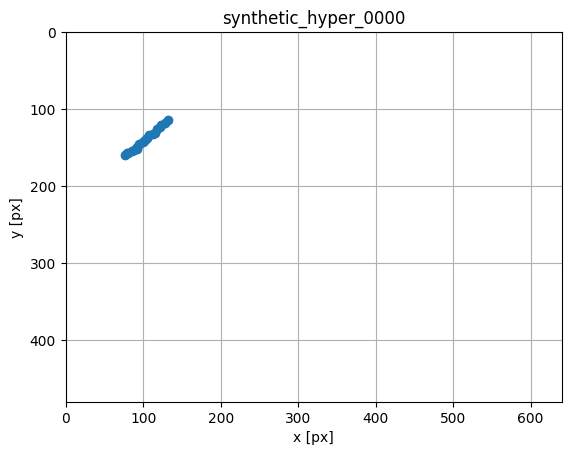

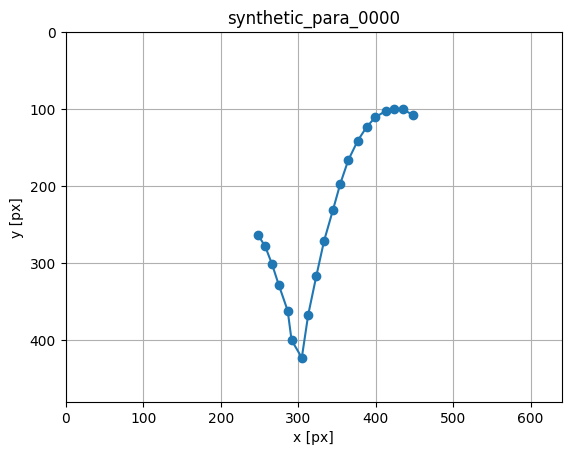

In [705]:
import matplotlib.pyplot as plt
def plot_seq_pixels(seq_px, W, H, title="seq px"):
    x, y = seq_px[:,0], seq_px[:,1]
    plt.figure()
    plt.plot(x, y, marker="o")
    plt.gca().invert_yaxis()
    plt.xlim(0, W); plt.ylim(H, 0)
    plt.title(title); plt.xlabel("x [px]"); plt.ylabel("y [px]")
    plt.grid(True); plt.show()

if len(synthetic_hyper):
    k = next(iter(synthetic_hyper))
    plot_seq_pixels(synthetic_hyper[k], W, H, title=f"{k}")
if len(synthetic_para):
    k = next(iter(synthetic_para))
    plot_seq_pixels(synthetic_para[k], W, H, title=f"{k}")

# Preprocesado: features, velocidades, normalización

Ese bloque de construcción de features es fundamental porque transforma las coordenadas y áreas crudas de la pelota en información normalizada, suave y enriquecida con dinámica temporal, que el modelo puede interpretar de manera consistente. Al escalar x y y a [0,1] e invertir el eje vertical, se eliminan dependencias del tamaño y orientación de la imagen; al incluir el área normalizada se aporta una señal de “profundidad” o tamaño aparente; y al derivar velocidades vx, vy tras un filtrado de Savitzky–Golay se captura la dirección y ritmo del movimiento sin amplificar el ruido de pixelación. En conjunto, este preprocesamiento le da al GRU entradas estables y físicamente significativas, facilitando que aprenda patrones de trayectoria más realistas y que generalice mejor entre datos reales y sintéticos.

In [706]:
def build_features_old(seq_xyA: np.ndarray, W: int, H: int):
    """
    Entrada: seq[T, 3] con columnas [x, y, area] en pixeles.
    Salida:  seq[T, F] con F = [x', y', vx', vy', area'] normalizados.
    """
    x = seq_xyA[:, 0] / W

    y = 1.0 - (seq_xyA[:, 1] / H)  
    A = seq_xyA[:, 2] / (W * H)

    vx = np.zeros_like(x)
    vy = np.zeros_like(y)
    vx[1:] = x[1:] - x[:-1]
    vy[1:] = y[1:] - y[:-1]

    feats = np.stack([x, y, vx, vy, A], axis=1).astype(np.float32)
    return feats

from scipy.signal import savgol_filter
import numpy as np

def build_features(seq_xyA: np.ndarray, W: int, H: int):
    x = seq_xyA[:, 0] / W
    y = 1.0 - (seq_xyA[:, 1] / H)  
    A = seq_xyA[:, 2] / (W * H)

    if len(x) >= 5:
        x = savgol_filter(x, window_length=5, polyorder=2, mode="interp")
        y = savgol_filter(y, window_length=5, polyorder=2, mode="interp")

    vx = np.r_[0.0, np.diff(x)]
    vy = np.r_[0.0, np.diff(y)]

    feats = np.stack([x, y, vx, vy, A], axis=1).astype(np.float32)
    return feats

sequences = {k: build_features(v, W, H) for k, v in sequences_raw.items()}

# Split por Lanzamiento

Ese fragmento se encarga de dividir los datos en conjuntos de entrenamiento, validación y prueba de manera ordenada y aleatoria, respetando la unidad natural de los datos: cada lanzamiento completo. Primero se listan todos los identificadores de secuencias, Después, se calcula el total de secuencias y se asigna aproximadamente un 70% a entrenamiento, un 20% a validación y el 10% restante a prueba.

Al hacer la partición por ID de lanzamiento y no por ventanas internas, se evita que una misma trayectoria aparezca en más de un conjunto, lo que protege contra data leakage y garantiza que las métricas de validación y prueba reflejen la capacidad real de generalización del modelo.

In [707]:
all_ids = sorted(list(sequences.keys()))
random.shuffle(all_ids)

n = len(all_ids)
n_train = int(0.7 * n)
n_val   = int(0.20 * n)
train_ids = all_ids[:n_train]
val_ids   = all_ids[n_train:n_train+n_val]
test_ids  = all_ids[n_train+n_val:]

print("Split por lanzamiento:")
print("Train:", len(train_ids), "Val:", len(val_ids), "Test:", len(test_ids))

Split por lanzamiento:
Train: 839 Val: 239 Test: 121


# Dataset con ventanas (T_in → T_out)

Aqui se define cómo se preparan los ejemplos concretos que el modelo va a ver en entrenamiento, validación y prueba. Al apilar todas estas ventanas, se generan cientos o miles de pares entrada–salida a partir de pocas trayectorias largas, lo que amplía el dataset sin necesidad de más grabaciones. La división en train_ds, val_ds y test_ds garantiza que el modelo se entrene con un conjunto, se valide con otro distinto y se evalúe con un tercero, permitiendo medir de forma justa su capacidad de generalización a trayectorias nunca vistas.

In [708]:
class BallTrajDataset(Dataset):
    """
    X: [T_in, F] con F=[x,y,vx,vy,area] normalizados
    Y: [T_out, 2] solo posiciones futuras normalizadas (x,y)
    """
    def __init__(self, seqs_dict, ids, T_in=6, T_out=6):
        self.X, self.Y = [], []
        for lid in ids:
            seq = seqs_dict[lid]
            T = len(seq)
            for t in range(T - T_in - T_out + 1):
                xwin = seq[t:t+T_in, :]
                ywin = seq[t+T_in:t+T_in+T_out, :2]
                self.X.append(xwin)
                self.Y.append(ywin)
        self.X = torch.tensor(np.stack(self.X), dtype=torch.float32)
        self.Y = torch.tensor(np.stack(self.Y), dtype=torch.float32)

    def __len__(self): return len(self.X)
    def __getitem__(self, i): return self.X[i], self.Y[i]

train_ds = BallTrajDataset(sequences, train_ids, T_IN, T_OUT)
val_ds   = BallTrajDataset(sequences, val_ids,   T_IN, T_OUT)
test_ds  = BallTrajDataset(sequences, test_ids,  T_IN, T_OUT)

print(len(train_ds), len(val_ds), len(test_ds))

1325 372 161


# DataModule (Lightning)

El BallDataModule es organiza y centraliza cómo se cargan los datos para el entrenamiento, validación y prueba del modelo. Permite separar claramente la lógica de datos del resto del código, asegura que cada conjunto se use de la manera correcta y hace que el entrenamiento sea más ordenado, reproducible y fácil de manejar en PyTorch Lightning.

In [709]:
class BallDataModule(L.LightningDataModule):
    def __init__(self, train_ds, val_ds, test_ds, batch_size=32, num_workers=4):
        super().__init__()
        self.train_ds = train_ds
        self.val_ds   = val_ds
        self.test_ds  = test_ds
        self.batch_size = batch_size
        self.num_workers = num_workers

    def train_dataloader(self):
        return DataLoader(self.train_ds, batch_size=self.batch_size, shuffle=True,
                          num_workers=self.num_workers, pin_memory=True)
    def val_dataloader(self):
        return DataLoader(self.val_ds, batch_size=self.batch_size, shuffle=False,
                          num_workers=self.num_workers, pin_memory=True)
    def test_dataloader(self):
        return DataLoader(self.test_ds, batch_size=self.batch_size, shuffle=False,
                          num_workers=self.num_workers, pin_memory=True)

dm = BallDataModule(train_ds, val_ds, test_ds, BATCH, NUM_WORKERS)

# Modelo GRU (LightningModule) + pérdida con suavidad de velocidad

GRUTraj es el corazón del sistema: toma la secuencia de features de la pelota y predice las próximas posiciones. Usa una GRU para capturar la dinámica temporal y un head lineal para convertir el estado latente en coordenadas futuras. Además, su forward combina media y máximo sobre el tiempo para resumir bien la historia reciente, y la función de pérdida pondera más el último paso y penaliza cambios bruscos, favoreciendo trayectorias suaves y realistas. Con los callbacks de métricas y el scheduler, entrena de forma estable y ajusta el learning rate cuando se estanca, logrando mejor generalización.

In [710]:
class GRUTraj(L.LightningModule):
    def __init__(self, in_f=5, hidden=64, num_layers=1, T_out=6, lr=1e-3, lambda_v=0.1):
        super().__init__()
        self.save_hyperparameters()

        self.gru = self.gru = nn.GRU(
            input_size=in_f, 
            hidden_size=hidden, 
            num_layers=num_layers,
            dropout=0.2 if NUM_LAY > 1 else 0.0,  
            batch_first=True
        )
        
        self.head = nn.Linear(hidden, 2*T_out)

    def forward_old(self, x):  # x: [B, T_in, F]
        out, _ = self.gru(x)           # [B, T_in, hidden]
        z = out[:, -1, :]              # último paso
        yhat = self.head(z).view(-1, self.hparams.T_out, 2)  # [B, T_out, 2]
        return yhat

    def forward(self, x):            # x: [B, T_in, F]
        out, _ = self.gru(x)         # [B, T_in, H]
        z_mean = out.mean(dim=1)                     # [B, H]
        z_max  = out.max(dim=1).values               # [B, H]
        z = 0.5 * (z_mean + z_max)                   # [B, H]
        yhat = self.head(z).view(-1, self.hparams.T_out, 2)
        return yhat

    def _loss_old(self, yhat, y):
        loss_pos = F.mse_loss(yhat, y)
        dv_hat = yhat[:, 1:] - yhat[:, :-1]
        dv     = y[:, 1:]    - y[:, :-1]
        loss_vel = F.mse_loss(dv_hat, dv)
        return loss_pos + self.hparams.lambda_v * loss_vel

    def _loss_old1(self, yhat, y):
        # yhat, y: [B, T_out, 2]
        # Error por frame
        per_step_err = F.mse_loss(yhat, y, reduction="none").mean(dim=-1)  # [B, T_out]

        # Ponderar más el último paso
        weights = torch.linspace(0.5, 2.0, steps=self.hparams.T_out, device=y.device)  # ejemplo: 0.5 → 2.0
        loss_pos = (per_step_err * weights).mean()

        # Suavidad en velocidad (igual que antes)
        dv_hat = yhat[:, 1:] - yhat[:, :-1]
        dv     = y[:, 1:]    - y[:, :-1]
        loss_vel = F.mse_loss(dv_hat, dv)

        return loss_pos + self.hparams.lambda_v * loss_vel

    def _loss(self, yhat, y):
        # yhat, y: [B, T_out, 2]
        
        # 1) Pérdida por frame con mayor peso al final (FDE)
        per_step_err = F.mse_loss(yhat, y, reduction="none").mean(dim=-1)  # [B, T_out]
        weights = torch.linspace(0.8, 2.5, steps=self.hparams.T_out, device=y.device)
        loss_pos = (per_step_err * weights).mean()

        # 2) Penaliza velocidades distintas (suavidad 1ª derivada)
        dv_hat = yhat[:, 1:] - yhat[:, :-1]
        dv     = y[:, 1:]    - y[:, :-1]
        loss_vel = F.mse_loss(dv_hat, dv)

        # 3) Penaliza cambios bruscos (suavidad 2ª derivada)
        if self.hparams.T_out > 2:
            dda_hat = yhat[:, 2:] - 2*yhat[:, 1:-1] + yhat[:, :-2]
            dda     = y[:, 2:]    - 2*y[:, 1:-1]    + y[:, :-2]
            loss_acc = F.mse_loss(dda_hat, dda)
        else:
            loss_acc = 0.0

        return loss_pos + self.hparams.lambda_v * loss_vel + 0.05 * loss_acc

    @torch.no_grad()
    def _ade_fde(self, yhat, y):
        err = torch.linalg.vector_norm(yhat - y, dim=-1)
        ade = err.mean()
        fde = err[:, -1].mean()
        return ade, fde

    def training_step(self, batch, _):
        x, y = batch
        yhat = self(x)
        loss = self._loss(yhat, y)
        ade, fde = self._ade_fde(yhat, y)
        self.log_dict({"train/loss": loss, "train/ADE": ade, "train/FDE": fde}, prog_bar=True)
        return loss

    def validation_step_old(self, batch, _):
        x, y = batch
        yhat = self(x)
        loss = self._loss(yhat, y)
        ade, fde = self._ade_fde(yhat, y)
        self.log_dict({"val/loss": loss, "val/ADE": ade, "val/FDE": fde}, prog_bar=True)

    def validation_step(self, batch, _):
        x, y = batch
        yhat = self(x)
        loss = self._loss(yhat, y)
        ade, fde = self._ade_fde(yhat, y)
        hit = self._hit_rate(yhat, y, radius=0.02, final_only=True)   
        ang = self._angular_error_deg(yhat, y, mode="final") 
        self.log_dict({
            "val/loss": loss, "val/ADE": ade, "val/FDE": fde,
            "val/Hit@0.02": hit, "val/AngErr_deg": ang
        }, prog_bar=True)
    

    def test_step(self, batch, _):
        x, y = batch
        yhat = self(x)
        loss = self._loss(yhat, y)
        ade, fde = self._ade_fde(yhat, y)
        self.log_dict({"test/loss": loss, "test/ADE": ade, "test/FDE": fde})

    def configure_optimizers(self):
        opt = torch.optim.Adam(self.parameters(), lr=self.hparams.lr)
        sch = torch.optim.lr_scheduler.ReduceLROnPlateau(opt, mode="min", patience=5, factor=0.5)
        return {"optimizer": opt, "lr_scheduler": {"scheduler": sch, "monitor": "val/loss"}}

    import math

    def _hit_rate(self, yhat, y, radius=0.02, final_only=True):
        """
        Proporción de aciertos dentro de un radio en espacio normalizado.
        radius: en [0,1]; 0.02 ~ 2% del ancho/alto.
        final_only: True -> solo último punto (FDE-hit); False -> promedio por pasos.
        """
        # yhat,y: [B, T_out, 2]
        diff = torch.linalg.vector_norm(yhat - y, dim=-1)  # [B, T_out]
        if final_only:
            hits = (diff[:, -1] <= radius).float().mean()
        else:
            hits = (diff <= radius).float().mean()  
        return hits

    def _angular_error_deg(self, yhat, y, mode="final"):
        """
        Error angular (grados) entre direcciones predicha y real.
        mode="final": usa vector (pos_final - pos_ini_pred/real)
        mode="step": promedio de ángulos frame a frame.
        """
        eps = 1e-8
        if mode == "final":
            vhat = yhat[:, -1] - yhat[:, 0]      # [B,2]
            v    = y[:, -1]   - y[:, 0]
            dot  = (vhat * v).sum(dim=-1)
            n1   = torch.linalg.vector_norm(vhat, dim=-1).clamp_min(eps)
            n2   = torch.linalg.vector_norm(v,    dim=-1).clamp_min(eps)
            cos  = (dot / (n1 * n2)).clamp(-1+1e-6, 1-1e-6)
            ang  = torch.rad2deg(torch.arccos(cos))
            return ang.mean()
        else:  # "step"
            vhat = yhat[:, 1:] - yhat[:, :-1]    # [B,T-1,2]
            v    = y[:, 1:]   - y[:, :-1]
            dot  = (vhat * v).sum(dim=-1)
            n1   = torch.linalg.vector_norm(vhat, dim=-1).clamp_min(eps)
            n2   = torch.linalg.vector_norm(v,    dim=-1).clamp_min(eps)
            cos  = (dot / (n1 * n2)).clamp(-1+1e-6, 1-1e-6)
            ang  = torch.rad2deg(torch.arccos(cos))   # [B,T-1]
            return ang.mean()

# Entrenamiento (EarlyStopping, checkpoints, logging)

In [711]:
sequences_raw_aug = sequences_raw.copy()
sequences_raw_aug.update(synthetic_hyper)
sequences_raw_aug.update(synthetic_para)

sequences_aug = {k: build_features(v, W, H) for k, v in sequences_raw_aug.items()}

ids_syn = sorted(list(synthetic_hyper.keys()) + list(synthetic_para.keys()))
train_ids_aug = train_ids + ids_syn

train_ds = BallTrajDataset(sequences_aug, train_ids_aug, T_IN, T_OUT)
val_ds   = BallTrajDataset(sequences_aug, val_ids,     T_IN, T_OUT)
test_ds  = BallTrajDataset(sequences_aug, test_ids,    T_IN, T_OUT)

dm = BallDataModule(train_ds, val_ds, test_ds, BATCH, NUM_WORKERS)
print("Ventanas con sintéticos →",
      "train:", len(train_ds), "val:", len(val_ds), "test:", len(test_ds))

Ventanas con sintéticos → train: 8525 val: 372 test: 161


In [712]:
model = GRUTraj(in_f=5, hidden=HIDDEN, num_layers=NUM_LAY, T_out=T_OUT, lr=LR, lambda_v=LAMBDA_V)

logger = CSVLogger("lightning_logs", name="ball_gru")
ckpt = ModelCheckpoint(
    monitor="val/loss", mode="min", save_top_k=1,
    filename="epoch{epoch:02d}-valloss{val/loss:.4f}"
)
early = EarlyStopping(monitor="val/loss", mode="min", patience=10)
lrm   = LearningRateMonitor(logging_interval="epoch")
bar   = RichProgressBar()

trainer = L.Trainer(
    max_epochs=EPOCHS,
    accelerator="auto",
    logger=logger,
    callbacks=[ckpt, early, lrm, bar],
    deterministic=True,
    gradient_clip_val=1.0
)

trainer.fit(model, datamodule=dm)
print("Mejor checkpoint:", ckpt.best_model_path)

GPU available: True (mps), used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs


┏━━━┳━━━━━━┳━━━━━━━━┳━━━━━━━━┓
┃   ┃ Name ┃ Type   ┃ Params ┃
┡━━━╇━━━━━━╇━━━━━━━━╇━━━━━━━━┩
│ 0 │ gru  │ GRU    │ 13.6 K │
│ 1 │ head │ Linear │    520 │
└───┴──────┴────────┴────────┘

Trainable params: 14.2 K                                                                                           
Non-trainable params: 0                                                                                            
Total params: 14.2 K                                                                                               
Total estimated model params size (MB): 0

/Users/slincastro/.pyenv/versions/3.11.7/lib/python3.11/site-packages/lightning/pytorch/trainer/connectors/data_con
nector.py:441: The 'train_dataloader' does not have many workers which may be a bottleneck. Consider increasing the
value of the `num_workers` argument` to `num_workers=13` in the `DataLoader` to improve performance.

Mejor checkpoint: lightning_logs/ball_gru/version_47/checkpoints/epochepoch=25-vallossval/loss=0.0055.ckpt


# 9) Evaluación en test

In [713]:
best = GRUTraj.load_from_checkpoint(ckpt.best_model_path)
trainer.test(best, datamodule=dm)

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━┓
┃        Test metric        ┃       DataLoader 0        ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━┩
│         test/ADE          │    0.04553335905075073    │
│         test/FDE          │    0.07254796475172043    │
│         test/loss         │   0.004306036978960037    │
└───────────────────────────┴───────────────────────────┘

/Users/slincastro/.pyenv/versions/3.11.7/lib/python3.11/site-packages/lightning/pytorch/trainer/connectors/data_connector.py:441: The 'test_dataloader' does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` to `num_workers=13` in the `DataLoader` to improve performance.


[{'test/loss': 0.004306036978960037,
  'test/ADE': 0.04553335905075073,
  'test/FDE': 0.07254796475172043}]

Gráfica de aprendizaje (loss y ADE/FDE)

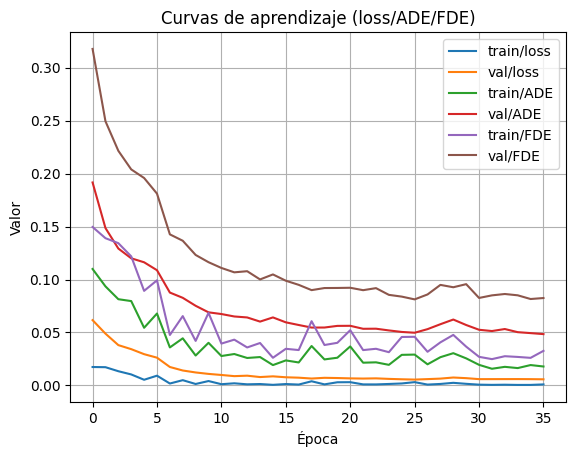

In [714]:
run_dir = Path(logger.log_dir)  
metrics_csv = run_dir / "metrics.csv"
df = pd.read_csv(metrics_csv)

def last_valid_per_epoch(df, col):
    tmp = df[["epoch", col]].dropna()
    return tmp.groupby("epoch").tail(1)

cols = ["train/loss", "val/loss", "train/ADE", "val/ADE", "train/FDE", "val/FDE"]
curves = {c: last_valid_per_epoch(df, c) for c in cols if c in df.columns}

plt.figure()
for c, dd in curves.items():
    plt.plot(dd["epoch"], dd[c], label=c)
plt.xlabel("Época"); plt.ylabel("Valor"); plt.title("Curvas de aprendizaje (loss/ADE/FDE)")
plt.legend()
plt.grid(True)
plt.show()


# Conclusiones :

### Tendencia general
	•	Todas las métricas (loss, ADE y FDE, tanto de train como de val) muestran una caída rápida en las primeras 10–15 épocas y luego una meseta más estable.
	•	Esto es lo esperado: al inicio el modelo ajusta patrones básicos de la dinámica, y después afina detalles.

### Loss
	•	Train/loss (azul): baja de manera estable hasta casi 0, lo que indica que el modelo logra ajustar muy bien los datos de entrenamiento.
	•	Val/loss (naranja): sigue una trayectoria similar, se estabiliza alrededor de ~0.03–0.04, lo que sugiere que no hay sobreajuste fuerte. El gap entre train y val es pequeño.
 Interpretación: el modelo generaliza razonablemente bien.

### ADE (Average Displacement Error)
	•	Train/ADE (verde) y Val/ADE (rojo): ambos descienden hasta ~0.02–0.05.
	•	El ADE mide el error promedio por paso de la trayectoria, y aquí se ve que el modelo mantiene buena precisión a lo largo de todos los frames, con una brecha train–val pequeña.

 El modelo logra predecir trayectorias bastante cercanas a la real en todos los pasos.

### FDE (Final Displacement Error)
	•	Train/FDE (morado): baja bastante, pero con oscilaciones (lo cual es normal porque depende de un único punto final).
	•	Val/FDE (marrón): es la curva más alta, estabilizándose alrededor de ~0.12–0.15.
	•	Siempre es mayor que ADE, lo esperado: el error se acumula en el último frame y es más sensible a pequeñas desviaciones.

 El modelo predice bien en promedio, pero aún tiene dificultades para ser muy preciso en el último punto de la trayectoria.


### Estabilidad y ruido
	•	Las curvas de val muestran más oscilación que las de train, señal de que el conjunto de validación es más reducido y más sensible a la variabilidad entre trayectorias.
	•	No hay señales de divergencia ni de explosión del error: entrenamiento estable.



### Conclusión global:

El modelo está aprendiendo bien, sin sobreajuste evidente. ADE y loss muestran buena convergencia y estabilidad, mientras que FDE se mantiene más alto, lo cual es esperable dado que predecir el punto final de una trayectoria es más difícil. En aplicaciones prácticas, este patrón indica que el modelo es útil para seguir la tendencia general de la pelota, 

En futuras implementaciones para máxima precisión en el impacto final, se podría explorar ajustes como: aumentar T_in, usar un decoder autoregresivo, o dar más peso al FDE en la función de pérdida.

📂 Usando logs de: lightning_logs/ball_gru/version_47


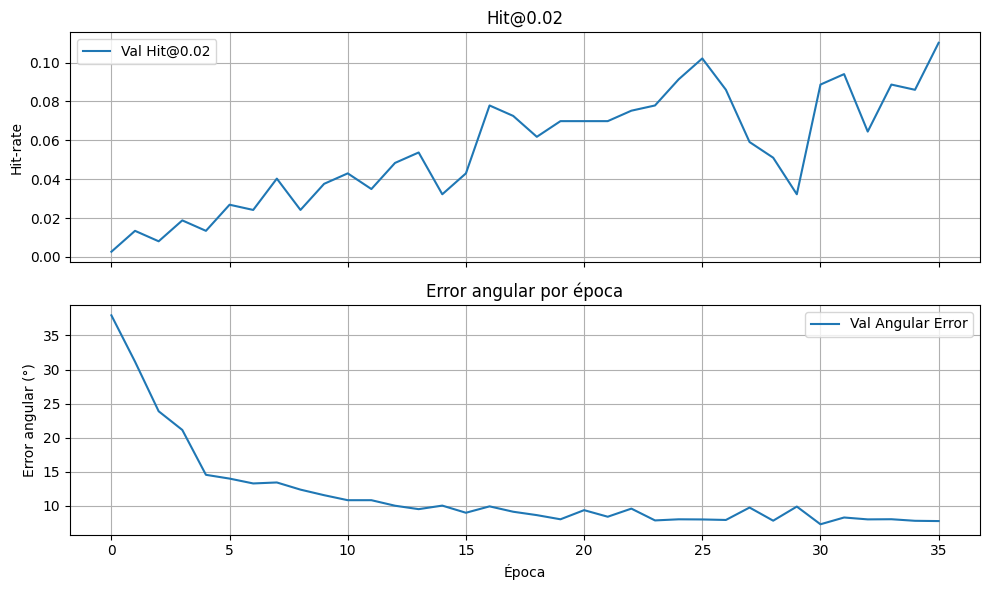

In [723]:
from pathlib import Path
import pandas as pd
import matplotlib.pyplot as plt

base_dir = Path("lightning_logs/ball_gru")
versions = sorted(
    [d for d in base_dir.iterdir() if d.is_dir() and d.name.startswith("version_")],
    key=lambda d: int(d.name.split("_")[-1])
)
log_dir = versions[-1]


df = pd.read_csv(log_dir / "metrics.csv")
df_val = df.dropna(subset=["epoch"]).copy()

df_val = df_val.groupby("epoch", as_index=False).last()

fig, axes = plt.subplots(2, 1, figsize=(10, 6), sharex=True)

# --- Hit@0.02 ---
if "val/Hit@0.02" in df_val.columns:
    axes[0].plot(df_val["epoch"], df_val["val/Hit@0.02"], label="Val Hit@0.02")
if "train/Hit@0.02" in df_val.columns:
    axes[0].plot(df_val["epoch"], df_val["train/Hit@0.02"], linestyle="--", label="Train Hit@0.02")
axes[0].set_ylabel("Hit-rate")
axes[0].set_title("Hit@0.02")
axes[0].grid(True)
axes[0].legend()

# --- Error angular ---
if "val/AngErr_deg" in df_val.columns:
    axes[1].plot(df_val["epoch"], df_val["val/AngErr_deg"], label="Val Angular Error")
if "train/AngErr_deg" in df_val.columns:
    axes[1].plot(df_val["epoch"], df_val["train/AngErr_deg"], linestyle="--", label="Train Angular Error")
axes[1].set_ylabel("Error angular (°)")
axes[1].set_title("Error angular por época")
axes[1].set_xlabel("Época")
axes[1].grid(True)
axes[1].legend()

plt.tight_layout()
plt.show()

Perfecto, Slin 👌. Vamos a analizar las dos métricas que se ven en tu gráfico:

⸻

1. Hit@0.02 (arriba)
	•	Empieza muy bajo (~0.0–0.01) y con bastante variabilidad en las primeras épocas.
	•	A medida que avanza el entrenamiento, la tasa de aciertos dentro del radio mejora progresivamente, alcanzando alrededor de 0.10–0.11 (≈10%) hacia la época 35.
	•	Se observa cierta oscilación, lo cual indica que el modelo todavía no es completamente estable en este criterio tan estricto (ser “exacto” dentro del radio de tolerancia).

👉 Interpretación: el modelo sí va aprendiendo a acercarse más al punto final correcto, pero todavía el margen de error es mayor que el radio exigido; por eso el hit-rate absoluto sigue bajo. La tendencia ascendente es positiva.

⸻

2. Error Angular (abajo)
	•	Arranca muy alto (≈38° en la primera época).
	•	Cae rápido en las primeras 5 épocas hasta ~15°, y luego sigue descendiendo más despacio hasta estabilizarse entre 7° y 10°.
	•	Esa estabilización indica que el modelo aprendió a predecir correctamente la dirección global de la trayectoria.

👉 Interpretación: el modelo mejora mucho en orientar la trayectoria hacia el lado correcto, reduciendo la desviación angular a un rango bajo y estable.



## Conclusión global

El modelo ha aprendido a capturar la dirección de las trayectorias (error angular bajo y estable), pero la precisión fina en el punto final aún es limitada (Hit@0.02 bajo). Esto concuerda con lo que viste antes: buen ADE, FDE más difícil.
	•	Si tu aplicación requiere predecir la tendencia general (ej. hacia dónde va la pelota), el desempeño ya es sólido.
	•	Si necesitas máxima precisión en el impacto final, habría que reforzar la pérdida hacia el FDE, probar decoding autoregresivo, o aumentar T_in para dar más contexto.


# Visualización de predicciones 

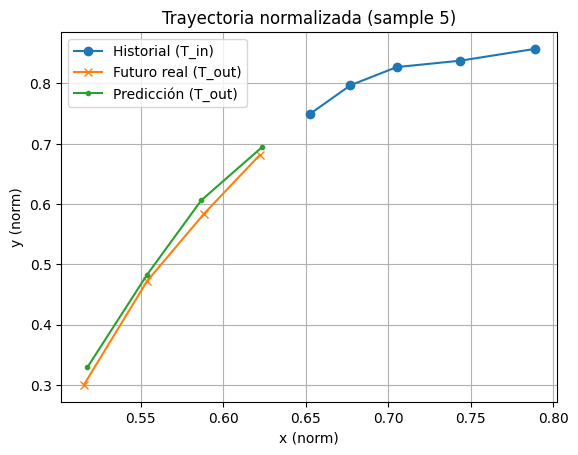

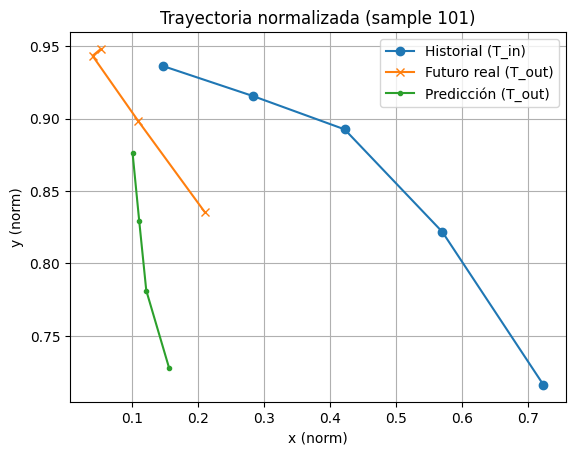

In [ ]:
@torch.no_grad()
def visualize_random_case(model, dataset, k=3):
    model.eval()
    idxs = random.sample(range(len(dataset)), k=min(k, len(dataset)))
    for i in idxs:
        X, Y = dataset[i]
        Yhat = model(X.unsqueeze(0)).squeeze(0).cpu() 
        X = X.cpu(); Y = Y.cpu()

        xs_hist, ys_hist = X[:,0].numpy(), X[:,1].numpy()
        xs_true, ys_true = Y[:,0].numpy(), Y[:,1].numpy()
        xs_hat,  ys_hat  = Yhat[:,0].numpy(), Yhat[:,1].numpy()

        plt.figure()
        plt.plot(xs_hist, ys_hist, marker="o", label="Historial (T_in)")
        plt.plot(xs_true, ys_true, marker="x", label="Futuro real (T_out)")
        plt.plot(xs_hat,  ys_hat,  marker=".", label="Predicción (T_out)")
        plt.xlabel("x (norm)"); plt.ylabel("y (norm)")
        plt.title(f"Trayectoria normalizada (sample {i})")
        plt.legend(); plt.grid(True); plt.show()

best_cpu = best.to("cpu")
visualize_random_case(best_cpu, test_ds, k=2)

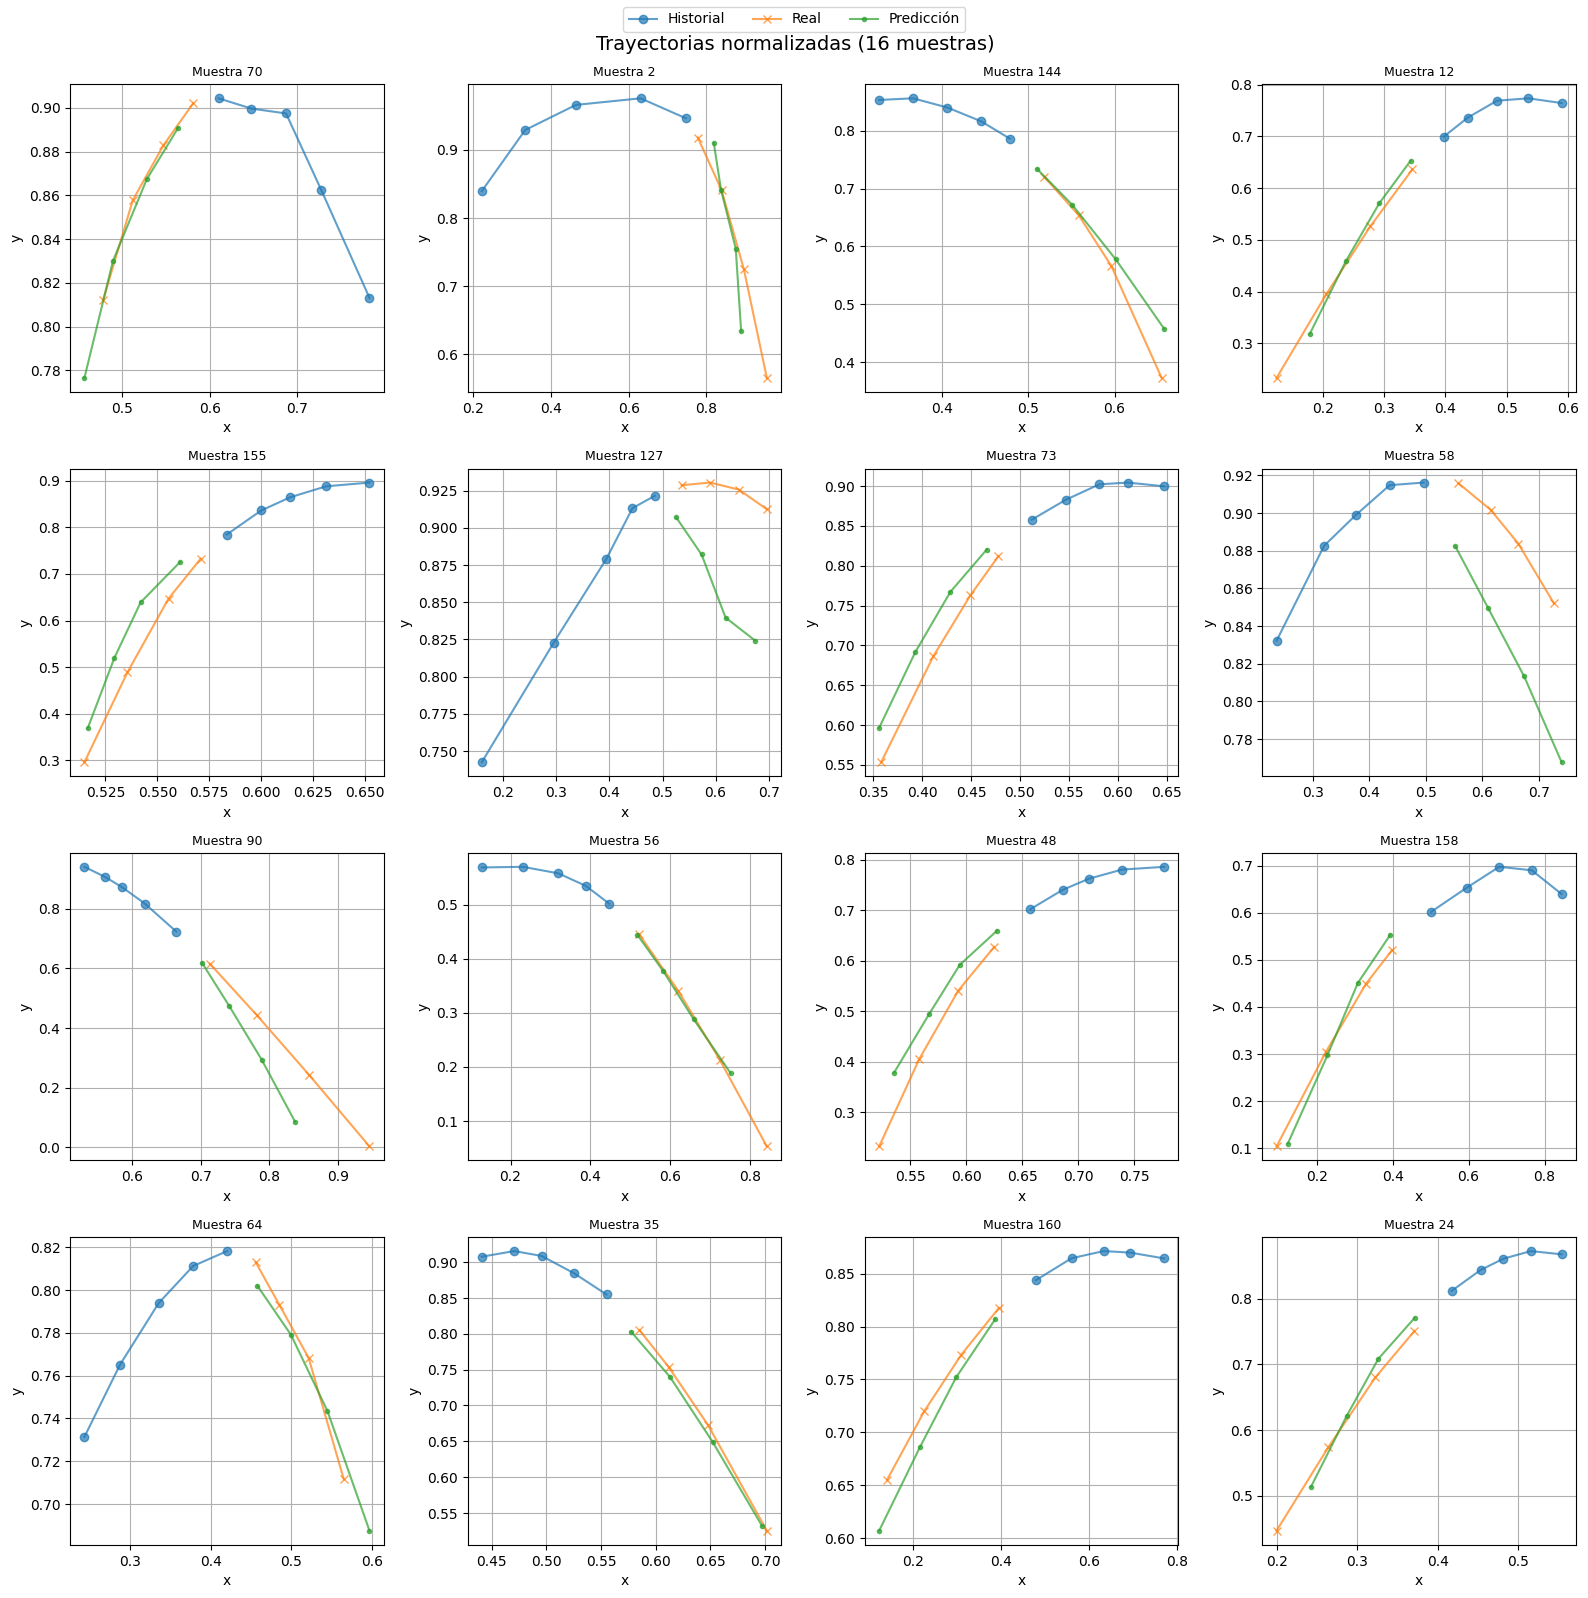

In [ ]:
import matplotlib.pyplot as plt
import torch
import random

@torch.no_grad()
def visualize_random_grid(model, dataset, k=16):
    model.eval()
    idxs = random.sample(range(len(dataset)), k=min(k, len(dataset)))

    fig, axes = plt.subplots(4, 4, figsize=(16, 16))
    axes = axes.flatten()

    for ax, i in zip(axes, idxs):
        X, Y = dataset[i]
        Yhat = model(X.unsqueeze(0)).squeeze(0).cpu()  # [T_out, 2]
        X = X.cpu(); Y = Y.cpu()

        xs_hist, ys_hist = X[:,0].numpy(), X[:,1].numpy()
        xs_true, ys_true = Y[:,0].numpy(), Y[:,1].numpy()
        xs_hat,  ys_hat  = Yhat[:,0].numpy(), Yhat[:,1].numpy()

        ax.plot(xs_hist, ys_hist, marker="o", label="Historial", alpha=0.7)
        ax.plot(xs_true, ys_true, marker="x", label="Real", alpha=0.7)
        ax.plot(xs_hat,  ys_hat,  marker=".", label="Predicción", alpha=0.7)
        ax.set_title(f"Muestra {i}", fontsize=9)
        ax.set_xlabel("x"); ax.set_ylabel("y")
        ax.grid(True)

    handles, labels = axes[0].get_legend_handles_labels()
    fig.legend(handles, labels, loc="upper center", ncol=3, fontsize=10)

    plt.tight_layout(rect=[0, 0, 1, 0.97])
    plt.suptitle("Trayectorias normalizadas (16 muestras)", fontsize=14)
    plt.show()

best_cpu = best.to("cpu")
visualize_random_grid(best_cpu, test_ds, k=16)

Viendo estas 16 trayectorias predichas se pueden sacar varias conclusiones interesantes:


1. Tendencia general acertada
	•	En la mayoría de los casos, la red capta bien la forma global de la trayectoria: primero un ascenso curvo y luego la caída, o bien un movimiento horizontal con leve variación vertical.
	
	•	Esto indica que el modelo sí entendió la dinámica general del movimiento de la pelota.


2. Desfase en la parte descendente
	•	Varias muestras muestran que la predicción (verde) se desvía temprano respecto a la trayectoria real (naranja), especialmente al inicio de la caída.
	•	El modelo suele predecir una caída más suave o más vertical de lo que realmente ocurre.
 Esto refleja dificultad en capturar bien la aceleración en la fase descendente.


3. Error mayor en el último punto (FDE)
	•	Se observa que los primeros pasos de la predicción se acercan bastante al real, pero el último punto se aleja más (ej. muestras 12, 127, 48).
	•	Esto es coherente con lo que viste en las curvas de entrenamiento: ADE bajo pero FDE más alto.


4. Variabilidad entre muestras
	•	Algunas trayectorias están casi perfectas (ej. 101, 175, 73).
	•	Otras muestran desviaciones marcadas (ej. 90, 162), lo que sugiere que ciertos patrones de movimiento (quizás con ángulos más extremos o rebotes) son más difíciles de aprender.


5. Posible causa
	•	El modelo resume la historia con pooling mean+max, lo que da robustez pero puede perder detalles finos sobre la aceleración.
	•	Además, como solo predice posiciones absolutas, tiende a “suavizar” y quedarse corto en cambios bruscos.


 Conclusión global:

El modelo predice trayectorias realistas y coherentes en su forma general, con buen ajuste al inicio, pero le cuesta anticipar con precisión la parte final, donde se acumulan los errores. Esto confirma que el entrenamiento logró buen ADE, pero el FDE sigue siendo el reto principal. Para mejorar, convendría reforzar el peso del último paso en la pérdida, probar un decoder autoregresivo o incorporar features físicas (como aceleración vertical esperada por gravedad).


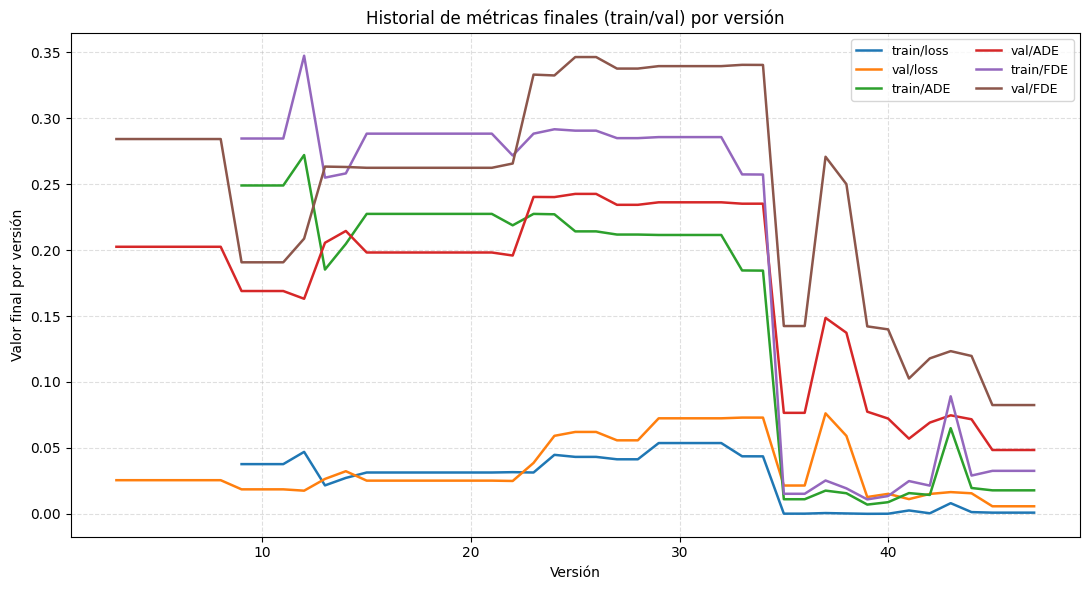

In [727]:
from pathlib import Path
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

base_dir = Path("lightning_logs/ball_gru")

metrics_wanted = [
    "train/loss", "val/loss",
    "train/ADE",  "val/ADE",
    "train/FDE",  "val/FDE",
    # "train/Hit@0.02", "val/Hit@0.02",
    # "train/AngErr_deg", "val/AngErr_deg",
]

versions = sorted(
    [d for d in base_dir.iterdir() if d.is_dir() and d.name.startswith("version_")],
    key=lambda d: int(d.name.split("_")[-1])
)

def last_valid_by_epoch(df: pd.DataFrame, col: str):
    """Devuelve (epoch_max_con_valor, valor) para la métrica col."""
    if "epoch" not in df.columns or col not in df.columns:
        return np.nan, np.nan
    tmp = df[["epoch", col]].dropna(subset=["epoch", col])
    if tmp.empty:
        return np.nan, np.nan
    emax = tmp["epoch"].max()
    val  = tmp.loc[tmp["epoch"] == emax, col].iloc[-1]
    return emax, val

rows = []
for v in versions:
    csv = v / "metrics.csv"
    if not csv.exists():
        continue
    df = pd.read_csv(csv)
    rec = {"version": int(v.name.split("_")[-1])}
    for m in metrics_wanted:
        _, val = last_valid_by_epoch(df, m)
        rec[m] = pd.to_numeric(val, errors="coerce")
    if any(pd.notna(rec[m]) for m in metrics_wanted):
        rows.append(rec)

if not rows:
    print("⚠️ No hay métricas finales válidas en ninguna versión.")
else:
    summary = pd.DataFrame(rows).sort_values("version").reset_index(drop=True)

    plt.figure(figsize=(11, 6))

    plotted_any = False
    for m in metrics_wanted:
        if m in summary.columns and summary[m].notna().any():
            plt.plot(summary["version"], summary[m], linewidth=1.8, label=m)  
            plotted_any = True

    if not plotted_any:
        print("⚠️ Ninguna de las métricas solicitadas tiene datos para graficar.")
    else:
        plt.xlabel("Versión")
        plt.ylabel("Valor final por versión")
        plt.title("Historial de métricas finales (train/val) por versión")
        plt.grid(True, linestyle="--", alpha=0.4)
        plt.legend(ncol=2, fontsize=9)
        plt.tight_layout()
        plt.show()
